In [ ]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from pathlib import Path
from torch.optim import Adam
from matplotlib import pyplot as plt
from utils.plotting import plot_celegans_neural_data

device = 'cuda'

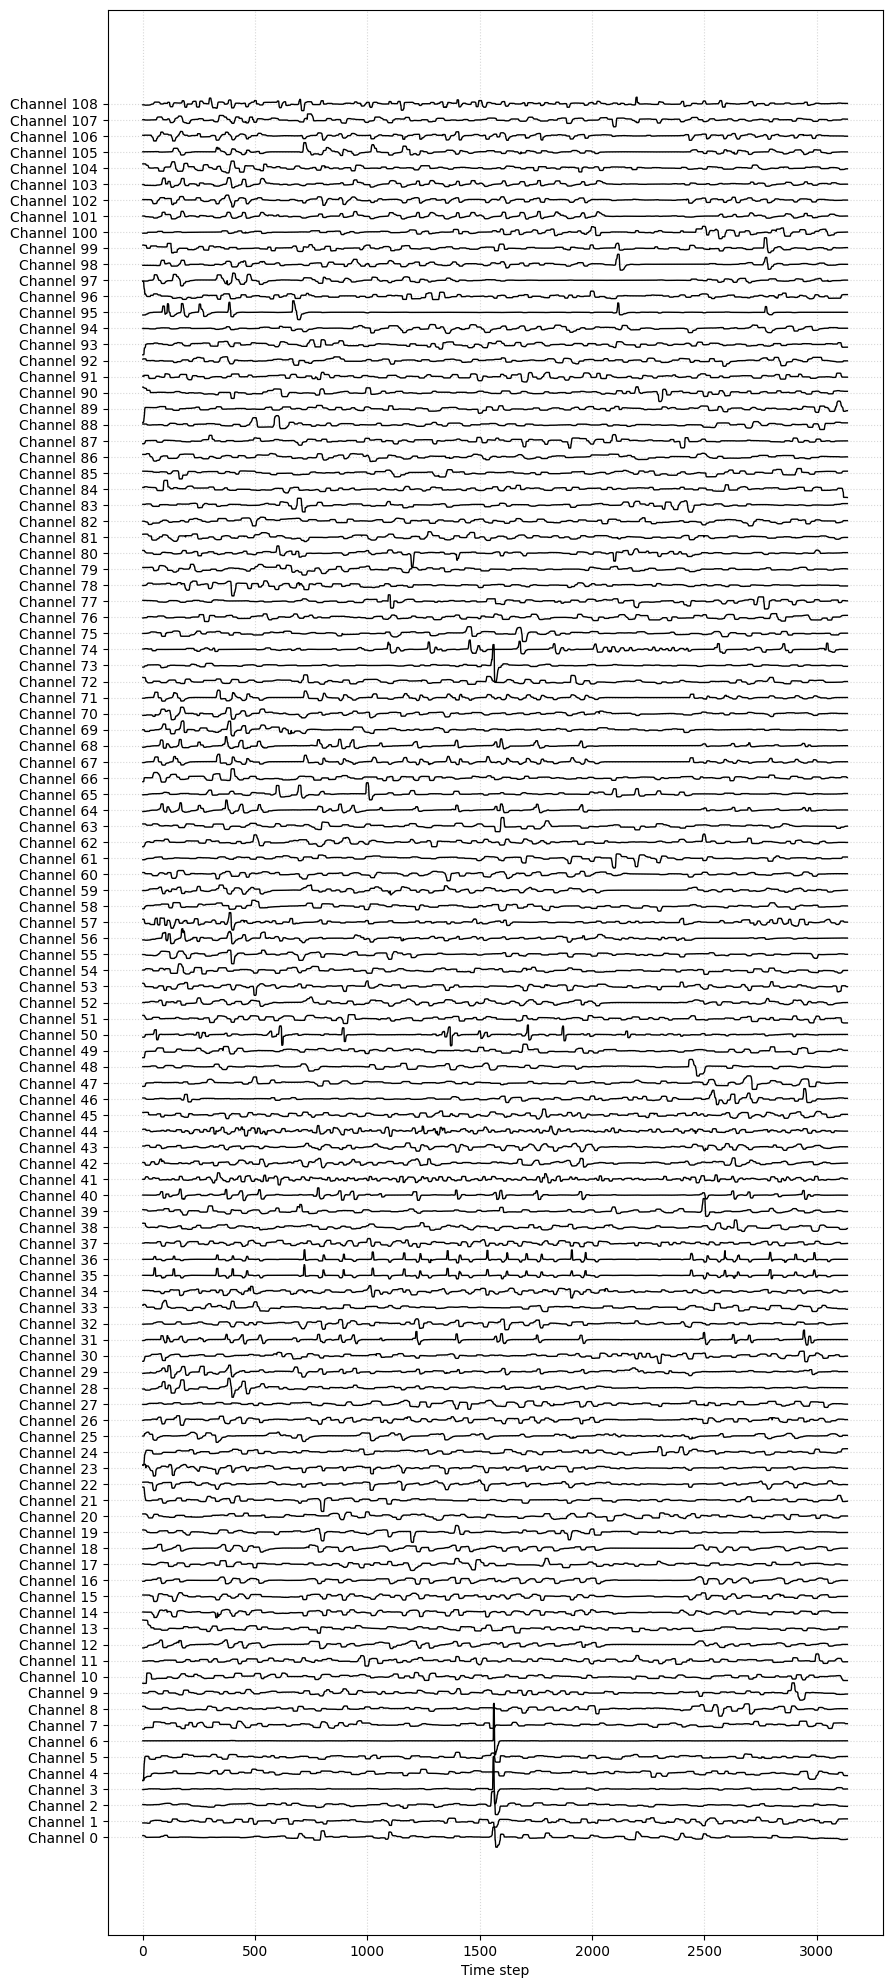

In [5]:
x_neural = np.genfromtxt(Path.cwd() / 'datasets' / 'CElegans' / 'worm_1' / 'original_data.csv' , delimiter=",", dtype=np.float32)
x_behavior = np.genfromtxt(Path.cwd() / 'datasets' / 'CElegans' / 'worm_1' / 'behavioural_state.csv' , delimiter=",", dtype=str)

x_neural = torch.FloatTensor(x_neural).to(device)
x_neural = (x_neural - x_neural.mean(dim=(0), keepdim=True)) / x_neural.std(dim=(0), keepdim=True)

behaviour_dict = {
    'fwd': 0,
    'slow': 1,
    'rev1': 2,
    'rev2': 3,
    'revsus': 4,
    'dt': 5,
    'vt': 6,
    'nostate': 7
} 

x_behavior = [behaviour_dict[x] for x in x_behavior]
x_behavior = torch.LongTensor(x_behavior).to(device)

channels = x_neural.shape[1]
plot_celegans_neural_data(x_neural)



  0%|          | 40/50000 [00:00<07:16, 114.46it/s, Loss markov=0.106, Loss behavior=2.07, Loss total=0.498]

100%|██████████| 50000/50000 [06:05<00:00, 136.83it/s, Loss markov=0.0191, Loss behavior=0.00916, Loss total=0.0171]


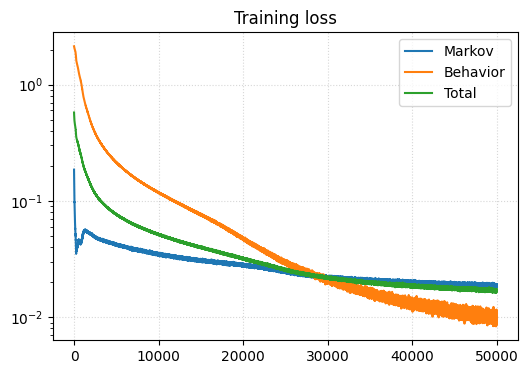

In [49]:
from models.bundlenet import BundleNET

behavior_decoder = nn.LazyLinear(8)
model = BundleNET(noise_std=0.05, behavior_decoder=behavior_decoder, gamma=0.2).to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

loss_history = model.fit(x_neural, behavior=x_behavior, optimizer=optimizer, epochs=50000)
plt.figure(figsize=(6,4))
plt.plot(loss_history['Markov'], label='Markov')
plt.plot(loss_history['Behavior'], label='Behavior')
plt.plot(loss_history['Total'], label='Total')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.title('Training loss')
plt.yscale('log')


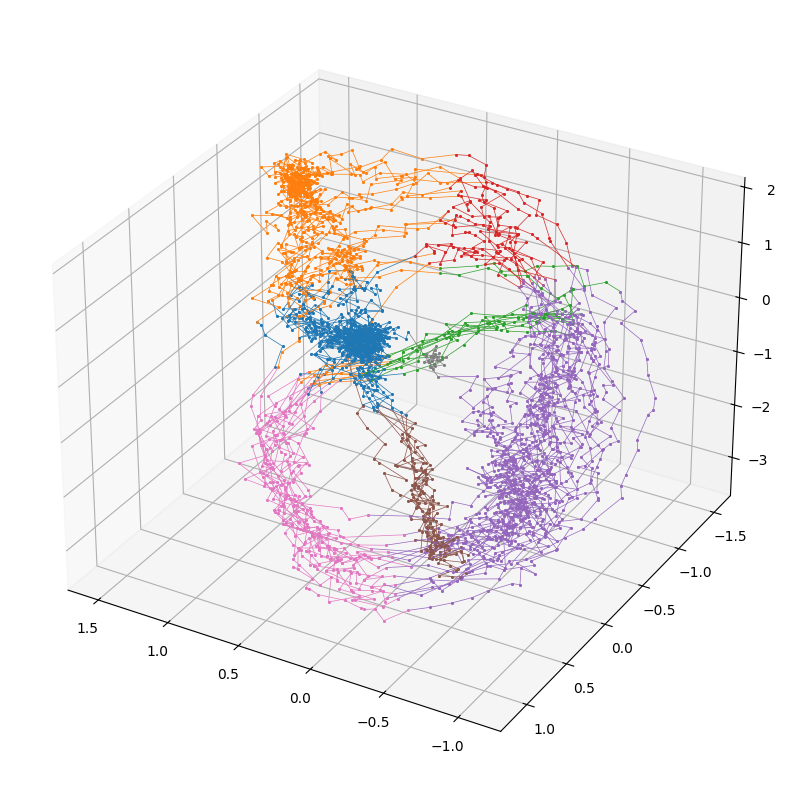

In [50]:
z_latent = model.encode(x_neural.unsqueeze(0)).squeeze(0).detach().cpu()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d', azim=120)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for t in range(z_latent.shape[0]-1):

    z_t = z_latent[t,:]
    z_t_p1 = z_latent[t+1,:]
    col = colors[x_behavior[t]]
    ax.plot([z_t[0], z_t_p1[0]], [z_t[1], z_t_p1[1]], [z_t[2], z_t_p1[2]] , lw=0.5, color=col, marker='.', markersize=2)


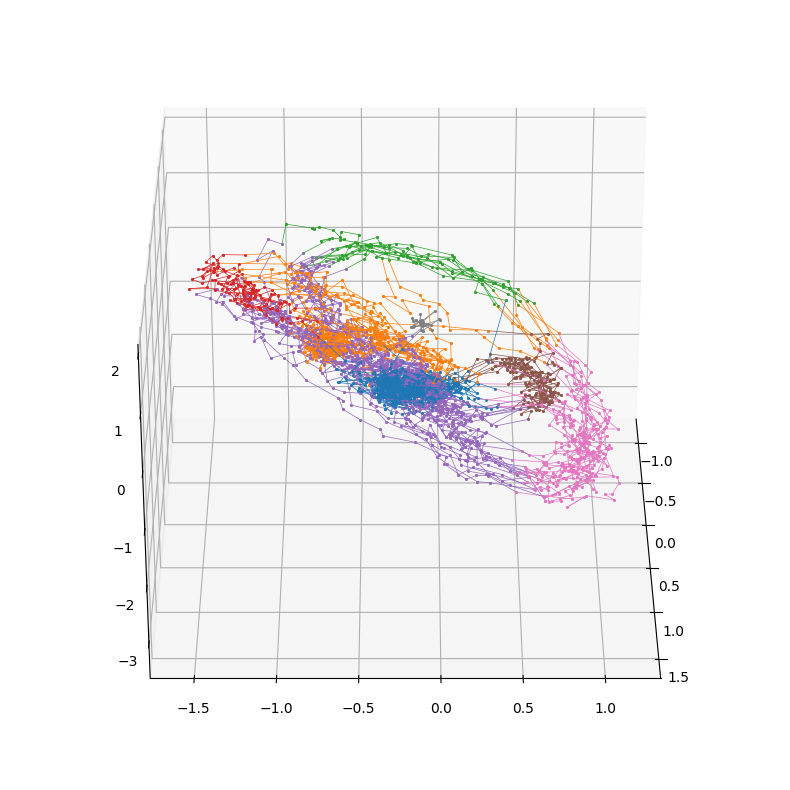

In [51]:
# Animazione
import matplotlib.animation as animation

z_latent = model.encode(x_neural.unsqueeze(0)).squeeze(0).detach().cpu()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d', azim=120)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for t in range(z_latent.shape[0]-1):

    z_t = z_latent[t,:]
    z_t_p1 = z_latent[t+1,:]
    col = colors[x_behavior[t]]
    ax.plot([z_t[0], z_t_p1[0]], [z_t[1], z_t_p1[1]], [z_t[2], z_t_p1[2]] , lw=0.5, color=col, marker='.', markersize=2)


def animate(i):
    ax.view_init(30, i/120 * 360, 0)
    return (ax,)

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=120, interval=1/30)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)

ani.save('Manifold_3d_2.gif', writer=writer)


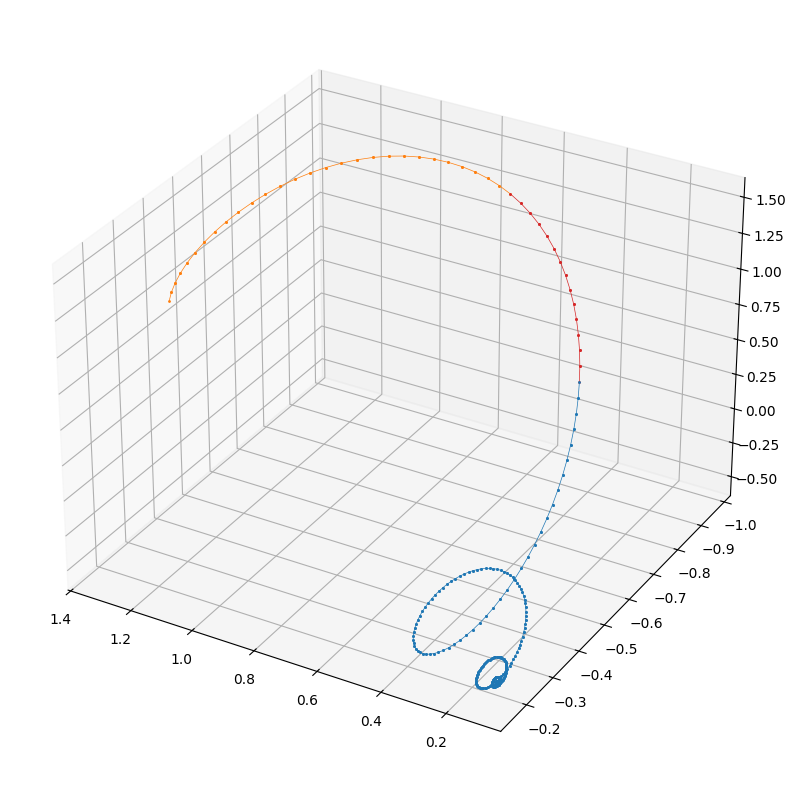

In [56]:
# Lo utilizzo come modello generativo e prevedo i 1000 step successivi
z_predictions, behavior_predictions = model.generate(x_init=x_neural[0,:], num_steps=1000)
z_predictions = z_predictions.detach().cpu()
behavior_predictions = behavior_predictions.detach().cpu()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d', azim=120)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for t in range(z_predictions.shape[0]-1):

    z_t = z_predictions[t,:]
    z_t_p1 = z_predictions[t+1,:]
    col = colors[behavior_predictions[t]]
    ax.plot([z_t[0], z_t_p1[0]], [z_t[1], z_t_p1[1]], [z_t[2], z_t_p1[2]] , lw=0.5, color=col, marker='.', markersize=2)
